In [1]:
!pip install duckdb

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb

In [3]:
con = duckdb.connect()
con.execute("SET s3_region='us-east-1'")
S3_BASE = "s3://jax-envision-public-data/study_1001/2025v3.3/tabular"

In [4]:
DOSE_MAPPING_REP1 = {
    4917: '5 mg/kg',  4918: 'Vehicle',  4919: '25 mg/kg',
    4920: '25 mg/kg', 4921: '5 mg/kg',  4922: 'Vehicle',
    4923: 'Vehicle',  4924: '25 mg/kg', 4925: '5 mg/kg'
}
DOSE_MAPPING_REP2 = {
    4926: '25 mg/kg', 4927: '5 mg/kg',  4928: 'Vehicle',
    4929: 'Vehicle',  4930: '25 mg/kg', 4931: '5 mg/kg',
    4932: '5 mg/kg',  4933: '25 mg/kg', 4934: 'Vehicle'
}

INJECTION_EVENTS = [
    {
        'name': 'Replicate 1, Dose 1',
        'short_name': 'Rep1_Dose1',
        'injection_time_utc': pd.Timestamp('2025-01-14 11:00:00'),
        'dates_to_load': ['2025-01-13', '2025-01-14', '2025-01-15'],
        'cages': list(DOSE_MAPPING_REP1.keys()),
        'dose_mapping': DOSE_MAPPING_REP1,
    },
    {
        'name': 'Replicate 1, Dose 2',
        'short_name': 'Rep1_Dose2',
        'injection_time_utc': pd.Timestamp('2025-01-17 22:00:00'),
        'dates_to_load': ['2025-01-17', '2025-01-18', '2025-01-19'],
        'cages': list(DOSE_MAPPING_REP1.keys()),
        'dose_mapping': DOSE_MAPPING_REP1,
    },
    {
        'name': 'Replicate 2, Dose 1',
        'short_name': 'Rep2_Dose1',
        'injection_time_utc': pd.Timestamp('2025-01-28 22:00:00'),
        'dates_to_load': ['2025-01-28', '2025-01-29', '2025-01-30'],
        'cages': list(DOSE_MAPPING_REP2.keys()),
        'dose_mapping': DOSE_MAPPING_REP2,
    },
    {
        'name': 'Replicate 2, Dose 2',
        'short_name': 'Rep2_Dose2',
        'injection_time_utc': pd.Timestamp('2025-01-31 11:00:00'),
        'dates_to_load': ['2025-01-30', '2025-01-31', '2025-02-01'],
        'cages': list(DOSE_MAPPING_REP2.keys()),
        'dose_mapping': DOSE_MAPPING_REP2,
    }
]

TIME_WINDOWS = {
    'baseline': (-180, -60),
    'immediate': (0, 30),
    'peak_early': (30, 90),
    'peak_sustained': (90, 180),
    'decline_early': (180, 300),
    'decline_late': (300, 420),
    'post_6hr': (360, 540),
    'post_12hr': (720, 900),
    'next_day': (1380, 1560)
}

WINDOW_ORDER = ['immediate', 'peak_early', 'peak_sustained', 'decline_early', 
                'decline_late', 'post_6hr', 'post_12hr', 'next_day']

In [5]:
def load_cage_data(cage_id, date_str, dose_mapping, file_type, query_filter=""):
    """Load parquet data for a specific cage and date."""
    path = f"{S3_BASE}/cage_id={cage_id}/date={date_str}/{file_type}.parquet"
    
    query = f"""
    SELECT * FROM read_parquet('{path}')
    WHERE resolution = 60
    {query_filter}
    """
    
    try:
        df = con.execute(query).fetchdf()
        df['cage_id'] = cage_id
        df['dose_group'] = dose_mapping[cage_id]
        return df
    except Exception as e:
        print(f"    ✗ Cage {cage_id}, Date {date_str}: {e}")
        return pd.DataFrame()


def load_injection_event_data(event, file_type, query_filter=""):
    """Load data for a single injection event."""
    print(f"Loading: {event['name']}")
    
    dfs = []
    for date_str in event['dates_to_load']:
        for cage_id in event['cages']:
            df = load_cage_data(cage_id, date_str, event['dose_mapping'], file_type, query_filter)
            if not df.empty:
                dfs.append(df)
    
    if not dfs:
        return pd.DataFrame()
    
    df_all = pd.concat(dfs, ignore_index=True)
    df_all['time'] = pd.to_datetime(df_all['time'])
    df_all['minutes_from_injection'] = (
        df_all['time'] - event['injection_time_utc']
    ).dt.total_seconds() / 60
    df_all = df_all[
        (df_all['minutes_from_injection'] >= -180) &
        (df_all['minutes_from_injection'] <= 1560)
    ]
    df_all['event'] = event['short_name']
    
    print(f"  Loaded {len(df_all):,} rows")
    return df_all


def load_all_events(file_type, query_filter=""):
    """Load data from all injection events."""
    all_data = []
    for event in INJECTION_EVENTS:
        df = load_injection_event_data(event, file_type, query_filter)
        if not df.empty:
            all_data.append(df)
    
    df_combined = pd.concat(all_data, ignore_index=True)
    print(f"\nTotal: {len(df_combined):,} rows")
    return df_combined

In [6]:
def compute_percent_change_all_features(df):
    """Compute percent change for all features."""
    features = df['name'].unique()
    all_results = []
    
    print(f"Computing percent change for {len(features)} features...")
    
    for feature in features:
        df_feat = df[df['name'] == feature].copy()
        baseline_start, baseline_end = TIME_WINDOWS['baseline']
        
        for (animal_id, dose_group, event), animal_df in df_feat.groupby(['animal_id', 'dose_group', 'event']):
            baseline_data = animal_df[
                (animal_df['minutes_from_injection'] >= baseline_start) &
                (animal_df['minutes_from_injection'] < baseline_end)
            ]['value']
            
            if baseline_data.empty or baseline_data.mean() == 0:
                continue
            
            baseline_mean = baseline_data.mean()
            
            for window_name, (win_start, win_end) in TIME_WINDOWS.items():
                if window_name == 'baseline':
                    continue
                
                window_data = animal_df[
                    (animal_df['minutes_from_injection'] >= win_start) &
                    (animal_df['minutes_from_injection'] < win_end)
                ]['value']
                
                if window_data.empty:
                    continue
                
                window_mean = window_data.mean()
                pct_change = ((window_mean - baseline_mean) / baseline_mean) * 100
                
                all_results.append({
                    'animal_id': animal_id,
                    'dose_group': dose_group,
                    'event': event,
                    'feature': feature,
                    'window': window_name,
                    'pct_change': pct_change
                })
    
    return pd.DataFrame(all_results)

In [7]:
# Load from animal_activity_db: locomotion, active, inactive, climbing
print("=== Loading Activity Features ===")
df_activity = load_all_events(
    file_type='animal_activity_db',
    query_filter=""  # Gets all: locomotion, active, inactive, climbing
)
print(f"Activity features: {df_activity['name'].unique()}")

# Load from animal_drinking: drinking, feeding
print("\n=== Loading Drinking & Feeding ===")
df_drinking_feeding = load_all_events(
    file_type='animal_drinking',
    query_filter=""
)
print(f"Drinking features: {df_drinking_feeding['name'].unique()}")

# Load from animal_tsdb_mvp: inferred_sleep
print("\n=== Loading Inferred Sleep ===")
df_sleep = load_all_events(
    file_type='animal_tsdb_mvp',
    query_filter="AND name = 'animal_bouts.inferred_sleep'"
)
print(f"Sleep features: {df_sleep['name'].unique()}")

# Combine all
df_combined = pd.concat([df_activity, df_drinking_feeding, df_sleep], ignore_index=True)
print(f"\n=== Combined ===")
print(f"Total rows: {len(df_combined):,}")
print(f"Features: {df_combined['name'].unique()}")

=== Loading Activity Features ===
Loading: Replicate 1, Dose 1


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

  Loaded 142,971 rows
Loading: Replicate 1, Dose 2


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

  Loaded 130,728 rows
Loading: Replicate 2, Dose 1


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

  Loaded 136,335 rows
Loading: Replicate 2, Dose 2


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

  Loaded 138,240 rows

Total: 548,274 rows
Activity features: ['animal_bouts.active' 'animal_bouts.inactive' 'animal_bouts.locomotion'
 'animal_bouts.climbing']

=== Loading Drinking & Feeding ===
Loading: Replicate 1, Dose 1


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

  Loaded 93,264 rows
Loading: Replicate 1, Dose 2


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

  Loaded 93,624 rows
Loading: Replicate 2, Dose 1


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

  Loaded 93,948 rows
Loading: Replicate 2, Dose 2


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

  Loaded 93,990 rows

Total: 374,826 rows
Drinking features: ['animal_bouts.drinking' 'animal_bouts.feeding']

=== Loading Inferred Sleep ===
Loading: Replicate 1, Dose 1


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

  Loaded 45,567 rows
Loading: Replicate 1, Dose 2


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

  Loaded 46,827 rows
Loading: Replicate 2, Dose 1


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

  Loaded 46,467 rows
Loading: Replicate 2, Dose 2


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

  Loaded 46,287 rows

Total: 185,148 rows
Sleep features: ['animal_bouts.inferred_sleep']

=== Combined ===
Total rows: 1,108,248
Features: ['animal_bouts.active' 'animal_bouts.inactive' 'animal_bouts.locomotion'
 'animal_bouts.climbing' 'animal_bouts.drinking' 'animal_bouts.feeding'
 'animal_bouts.inferred_sleep']


In [8]:
results_combined = compute_percent_change_all_features(df_combined)
print(f"Features: {results_combined['feature'].unique()}")
print(f"Animals: {results_combined['animal_id'].nunique()}")

Computing percent change for 7 features...
Features: ['animal_bouts.active' 'animal_bouts.inactive' 'animal_bouts.locomotion'
 'animal_bouts.climbing' 'animal_bouts.drinking' 'animal_bouts.feeding'
 'animal_bouts.inferred_sleep']
Animals: 54


In [ ]:
def individual_consistency_analysis(results_df, dose_group='25 mg/kg', window='peak_sustained'):
    """Correlate effect sizes across features within individuals."""
    subset = results_df[
        (results_df['dose_group'] == dose_group) &
        (results_df['window'] == window)
    ]
    
    pivot = subset.pivot_table(
        index=['animal_id', 'event'],
        columns='feature',
        values='pct_change'
    ).dropna()
    
    pivot.columns = pivot.columns.str.replace('animal_bouts.', '')
    
    print(f"Animals with complete data: {len(pivot)}")
    print(f"Features: {list(pivot.columns)}")
    
    corr = pivot.corr()
    
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
                vmin=-1, vmax=1, ax=ax)
    ax.set_title(f'Individual Consistency: Feature Correlations\n({dose_group}, {window})')
    plt.tight_layout()
    plt.show()
    
    return pivot, corr

pivot, corr = individual_consistency_analysis(results_combined, dose_group='25 mg/kg', window='peak_sustained')

In [9]:
results_combined = compute_percent_change_all_features(df_combined)
print(f"Features: {results_combined['feature'].unique()}")
print(f"Animals: {results_combined['animal_id'].nunique()}")

# Save results
results_combined.to_csv('individual_consistency_percent_change.csv', index=False)
print("Saved: individual_consistency_percent_change.csv")

Computing percent change for 7 features...
Features: ['animal_bouts.active' 'animal_bouts.inactive' 'animal_bouts.locomotion'
 'animal_bouts.climbing' 'animal_bouts.drinking' 'animal_bouts.feeding'
 'animal_bouts.inferred_sleep']
Animals: 54
Saved: individual_consistency_percent_change.csv


Animals with complete data: 31
Features: ['active', 'climbing', 'drinking', 'feeding', 'inactive', 'inferred_sleep', 'locomotion']


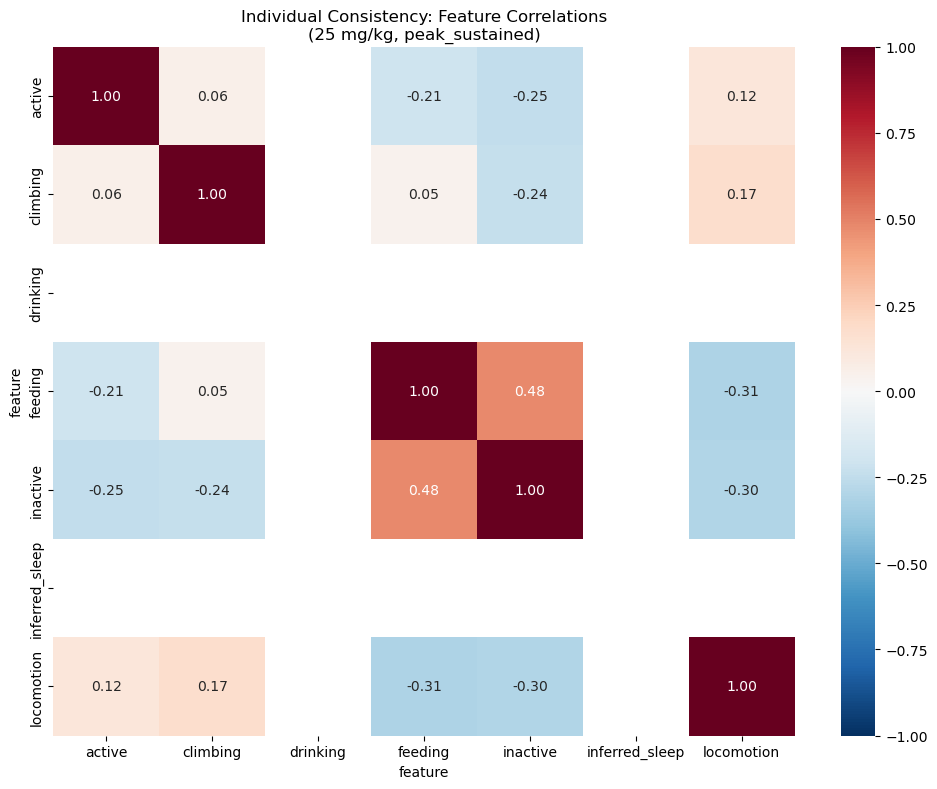


Saved:
  - individual_consistency_25_mgkg_peak_sustained.png
  - individual_responses_25_mgkg_peak_sustained.csv
  - correlation_matrix_25_mgkg_peak_sustained.csv
Animals with complete data: 31
Features: ['active', 'climbing', 'drinking', 'feeding', 'inactive', 'inferred_sleep', 'locomotion']


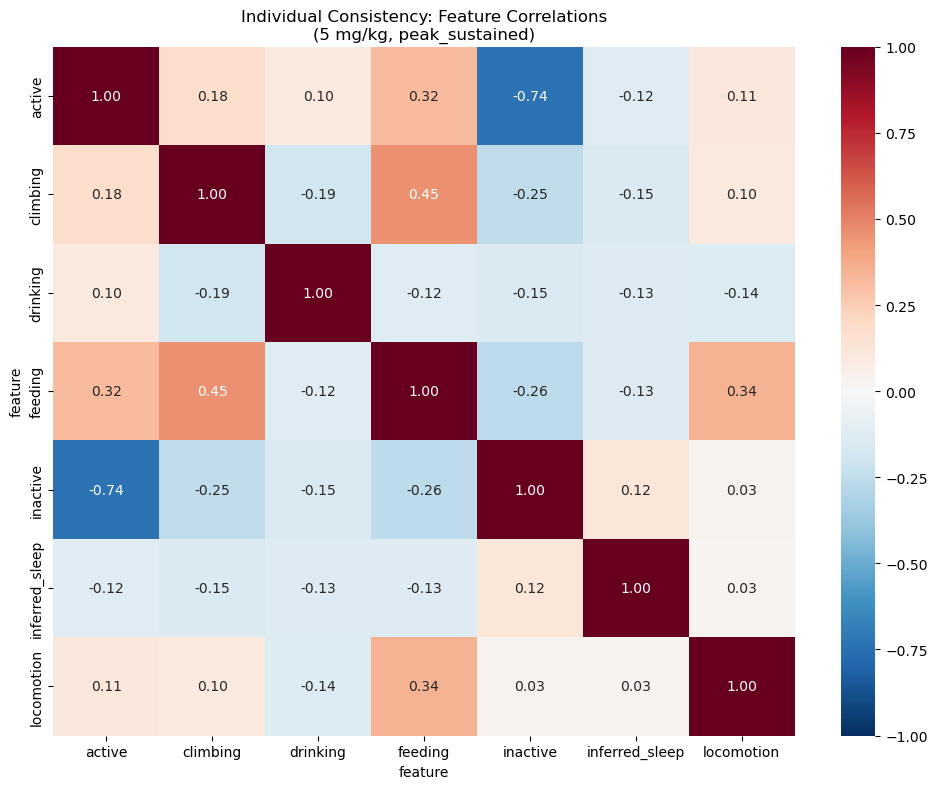


Saved:
  - individual_consistency_5_mgkg_peak_sustained.png
  - individual_responses_5_mgkg_peak_sustained.csv
  - correlation_matrix_5_mgkg_peak_sustained.csv


In [10]:
def individual_consistency_analysis(results_df, dose_group='25 mg/kg', window='peak_sustained'):
    """Correlate effect sizes across features within individuals."""
    subset = results_df[
        (results_df['dose_group'] == dose_group) &
        (results_df['window'] == window)
    ]
    
    pivot = subset.pivot_table(
        index=['animal_id', 'event'],
        columns='feature',
        values='pct_change'
    ).dropna()
    
    pivot.columns = pivot.columns.str.replace('animal_bouts.', '')
    
    print(f"Animals with complete data: {len(pivot)}")
    print(f"Features: {list(pivot.columns)}")
    
    corr = pivot.corr()
    
    # Plot and save
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
                vmin=-1, vmax=1, ax=ax)
    ax.set_title(f'Individual Consistency: Feature Correlations\n({dose_group}, {window})')
    plt.tight_layout()
    plt.savefig(f'individual_consistency_{dose_group.replace(" ", "_").replace("/", "")}_{window}.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Save pivot table and correlation matrix
    pivot.to_csv(f'individual_responses_{dose_group.replace(" ", "_").replace("/", "")}_{window}.csv')
    corr.to_csv(f'correlation_matrix_{dose_group.replace(" ", "_").replace("/", "")}_{window}.csv')
    
    print(f"\nSaved:")
    print(f"  - individual_consistency_{dose_group.replace(' ', '_').replace('/', '')}_{window}.png")
    print(f"  - individual_responses_{dose_group.replace(' ', '_').replace('/', '')}_{window}.csv")
    print(f"  - correlation_matrix_{dose_group.replace(' ', '_').replace('/', '')}_{window}.csv")
    
    return pivot, corr

# Run for 25 mg/kg
pivot_25, corr_25 = individual_consistency_analysis(results_combined, dose_group='25 mg/kg', window='peak_sustained')

# Also run for 5 mg/kg to compare
pivot_5, corr_5 = individual_consistency_analysis(results_combined, dose_group='5 mg/kg', window='peak_sustained')